<a href="https://github.com/Sunray0466/com_soc_sci.git">> Git repository link</a><br>
Currently working alone due to joining the course late. All work are done by s204133(me)

## Imports

In [2]:
import requests, pickle, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from joblib import Parallel, delayed
from bs4 import BeautifulSoup
from netwulf import visualize

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Week 1
### Part 1

In [4]:

link = "https://ic2s2-2023.org/program"
r = requests.get(link)
soup = BeautifulSoup(r.content)

researchers = set()
for link in soup.find_all("a"):
    if "keynote -" in link.getText().lower():
        researchers.add(link.getText().split("- ")[-1].title())
for i in soup.find_all("i"):
    # print(i.text)
    names = i.text.lower().replace("chair: ","")#.replace("<u>","").replace("</u>","")
    # print(names)
    for name in names.split(","):
        researchers.add(name.strip().title())
    # researchers.update(names.split(""))

researchers = sorted(researchers)
with open('list_researchers.pickle', 'wb') as handle:
    pickle.dump(researchers, handle)
    
print(len(researchers))

1488


> Q5 How many unique researchers do you get?

I got 1488 unique researchers

> Q6 Explain the process you followed to web-scrape the page. > Which choices did you make to accurately retreive as many names as > possible? Which strategies did you use to assess the quality of your > final list? Explain your reasoning and your choices > __(answer in max 150 words)__.

By inspecting the website, I found that the \<a\> objects had

    Keynote - {researcher name}
and that all \<i\> objects also had research name(s). I then inserted custom styles to easily identify whether it was the case for all of them and that I didn't get unintented targets:

    i {
        border: red solid !important;
    }
    a[href^="/keynotes"] {
        border: blue solid !important;
    }
Afterwards I just needed to remove unnessesary words like "Chair:" and check for and add multiple researchers in a single object

# Week 2

## Part 2: Ready Made vs Custom Made Data

> 1. What are pros and cons of the custom-made data used in Centola's experiment (the first study presented in the lecture) and the ready-made data used in Nicolaides's study (the second study presented in the lecture)? You can support your arguments based on the content of the lecture and the information you read in Chapter 2.3 of the book __(answer in max 150 words)__.

#### Custom-made data
##### Pros
- Controlled sample: the sample are easily assigned into groups
- Investigate casual relationships: how simple and complex contagion spreads
- Non-reactive: user are unaware of being part of experiment
##### Cons
- Cost: for maintaining server
- Artificial environments: website and mails may affect the subjects behaviour 

#### Ready-made data
##### Pros
- Big: large sample, from different parts of the world
- Always on and long time scales: able to track 24/7 throughout the year
- Non-reactive: user may be unaware of being part of experiment (unless stated in terms and conditions)
##### Cons
- Inaccesible: difficult to access due to privacy, ethics and also permission from company
- Dirty: people may cheat by taking bike or some form of transportation
- Drifting: updates to app look and feel may change subject behaviour.
- Algorithmically confounded: engineered to incentivise people to run through advertisement/social medias

> 2. How do you think these differences can influence the interpretation of the results in each study? __(answer in max 150 words)__
#### Custom-made data
Assigning groups may not reflect real world scenario such as number of connections, number of groups, size of groups etc.. There may also be outside influcence which the data doesn't capture. A small sample may also not experience rare events which might be relevant.

#### Ready-made data
A lot of data can be amassed and rare events are easier to observe and therefore quite representative of real scenario. Testing out new hypothesis may however prove to be difficult unless they work with the company 

In [5]:
# url
base_url   = "https://api.openalex.org/authors"
version    = ""
resource   = "?search="
parameters = None
search_url = base_url + version + resource
# print(search_url)

# retrieve researchers
with open('list_researchers.pickle', 'rb') as handle:
    researchers = pickle.load(handle)
# print("N researchers:",len(researchers))

data = []
for r in tqdm(researchers):
    query = search_url + r.lower()
    results = requests.get(query).json()["results"]

    # no hit
    if results == []:
        # print(True,)
        # try removing middle name
        if len(r_:=r.lower().split()) > 2:
            query = search_url + r_[0] + " " + r_[-1]
            results = requests.get(query).json()["results"]
            # if no hit again, skip
            if results == []: continue
        else: # skip researcher
            continue
    
    try: # debugging
        # choose researcher with highest h-index
        bi,bh = -1,-1
        for i,r in enumerate(results):
            h = r["summary_stats"]["h_index"]
            if h > bh:
                bi = i
                bh = h
        # get info
        if results[bi]["last_known_institution"] != None:
            lcc = results[bi]["last_known_institution"]["country_code"]
        else: 
            lcc = None
        info = {
            "display_name":results[bi]["display_name"],
            "id":results[bi]["id"],
            "h_index":results[bi]["summary_stats"]["h_index"],
            "works_count":results[bi]["works_count"],
            "works_api_url":results[bi]["works_api_url"],
            "last_country_code":lcc,
        }
    except:
        print(query,bi,results)
        break
    data.append(info)
    # print(data)
    # break
researchers_df = pd.DataFrame(data).drop_duplicates(subset="id")
researchers_df["id"] = researchers_df["id"].str.replace("https://openalex.org/","",regex=True)
researchers_df = researchers_df.sort_values(by="display_name").reset_index(drop=True)
researchers_df.to_pickle("df_researchers.pickle")
researchers_df

"results/id"
"results/display_name"
"results/works_api_url"
"results/summary_stats/h_index"
"results/works_count"

# Troubles
# - calculate h-index?
# - data is null

100%|██████████| 1488/1488 [14:03<00:00,  1.76it/s] 


'results/works_count'

# Week 3
### Part 1

In [7]:
researchers_df = pd.read_pickle("df_researchers.pickle")
researchers_dfm = researchers_df[(5<=researchers_df.works_count) & (researchers_df.works_count<=5000)]

url = "https://api.openalex.org/works?filter=author.id:"
filters = """
,cited_by_count:>10
&select=id,publication_year,cited_by_count,authorships,title,abstract_inverted_index,concepts
&per-page=200
&cursor=""".replace("\n","")

data = []
for i in tqdm(range(0,len(researchers_dfm),25)):
    query = url + "|".join(researchers_dfm.id.iloc[i:i+25]) + filters
    
    cursor = "*"
    # print(query+cursor)
    while True: # paginating
        meta,results,_ = requests.get(query+cursor).json().values()
        # check if empty page
        if (cursor := meta["next_cursor"]) == None: break
        
        # loop results
        for w in results:
            # filter co-author count
            if len(w["authorships"]) > 9:
                continue
            
            # filter concepts
            accept_level = [False,False]
            for concept in w["concepts"]:
                if concept["level"] == 0:
                    if concept["display_name"].lower() in ["sociology","psychology","economics","political science"]:
                        accept_level[0] = True
                    if concept["display_name"].lower() in ["mathematics","physics","computer science"]:
                        accept_level[1] = True
            if not all(accept_level):
                # print(accept_level)
                continue
            
            # extract info
            del w["concepts"]
            author_ids = []
            for authors in w["authorships"]:
                author_ids.append(authors["author"]["id"].replace("https://openalex.org/",""))
            del w["authorships"]
            w["author_ids"] = author_ids
            data.append(w)
    # break

  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [09:14<00:00, 11.79s/it]


In [8]:
data_df = pd.DataFrame(data).drop_duplicates(subset="id")
data_df["id"] = data_df["id"].str.replace("https://openalex.org/","",regex=True)
paper_df    = data_df[["id","publication_year","cited_by_count","author_ids"]]
abstract_df = data_df[["id","title","abstract_inverted_index"]]

paper_df.to_pickle("df_paper.pickle")
abstract_df.to_pickle("df_abstract.pickle")

# researchers_df = pd.read_pickle("df_researchers.pickle")
# paper_df = pd.read_pickle("df_paper.pickle")

# Q1
print("Number of works:",len(paper_df))

main_researchers = set(researchers_df.id)
co_researchers = set()
for authors in paper_df.author_ids:
    co_researchers.update(authors)
print("Number of collaborates:", len(co_researchers - main_researchers))
paper_df

Number of works: 10204
Number of collaborates: 15418


,id,publication_year,cited_by_count,author_ids
0,W3103362336,2009,6226,"[A5014647140, A5082953212, A5067142016]"
1,W2157082398,2008,1876,"[A5014647140, A5008033989, A5067142016]"
2,W2095072199,2005,713,[A5014647140]
3,W2102017123,2015,393,"[A5014647140, A5027903946, A5027079032]"
4,W2513567506,2017,355,"[A5072266097, A5027079032, A5014647140]"
...,...,...,...,...
11661,W2890190483,2018,12,"[A5040769818, A5038564141, A5061040384, A5086338693, A5087983500, A5022704573]"
11662,W3101533854,2016,11,"[A5023518080, A5007049707, A5080734907, A5006517585, A5035708783, A5024818901, A5008582408]"
11663,W2014914814,2014,11,"[A5034566276, A5065118727, A5066979752]"
11664,W2563782302,2017,11,"[A5008173961, A5059071793, A5082424766, A5067572513]"


> - **Dataset summary.** How many works are listed in your *IC2S2 papers* dataframe? How many unique researchers have co-authored these works? 

There are 10204 works listed, with 15418 collaborators.

> - **Efficiency in code.** Describe the strategies you implemented to make your code more efficient. How did your approach affect your code's execution time? __(answer in max 150 words)__

Use of filter to retrieve multiple works while also filtering out those with citation count of 10 or lower, increase targets to 200 per page and reduce amount of data recieved by selecting fields which we are interested in.

> - **Filtering Criteria and Dataset Relevance** Reflect on the rationale behind setting specific thresholds for the total number of works by an author, the citation count, the number of authors per work, and the relevance of works to specific fields. How do these filtering criteria contribute to the relevance of the dataset you compiled? Do you believe any aspects of Computational Social Science research might be underrepresented or overrepresented as a result of these choices? __(answer in max 150 words)__

- An author with few works could mean that they are new or not so active and therefore have few collaboration with others
- Citation count can be a measure for how good or relevant their works are. With few citation the work could be fairly new or just full of nonsense
- A high number of authors on one work could indicate that it was part of a project from an institute or company with alot other researchers who has also been working on it. The numbers would therefore be high while it was worked with a small group
- As we are dealing with researchers who has attended IC2S2, it makes sense to limit the fields to get works which are relevant for IC2S2

- These filter are used to keep the data relevant for IC2S2, by spreading out as much as possible while still being within the theme and represents it quite nicely

### Part 2

In [9]:
### co-researchers
researchers_df = pd.read_pickle("df_researchers.pickle")
paper_df       = pd.read_pickle("df_paper.pickle")

main_researchers = set(researchers_df.id)
co_researchers = set()
for authors in paper_df.author_ids:
    co_researchers.update(authors)
co_researchers = list(co_researchers - main_researchers)

## extract author data
url = "https://api.openalex.org/authors?filter=openalex_id:"
filters = """
&select=display_name,id,works_api_url,summary_stats,works_count,last_known_institution
&per-page=50
""".replace("\n","")


data = []
for i in tqdm(range(0,len(co_researchers),50)):
    query = url + "|".join(co_researchers[i:i+50]) + filters
    results = requests.get(query).json()["results"]
        
    for r in results:
        # get info
        if r["last_known_institution"] != None:
            lcc = r["last_known_institution"]["country_code"]
        else: 
            lcc = None
        info = {
            "display_name":r["display_name"],
            "id":r["id"],
            "h_index":r["summary_stats"]["h_index"],
            "works_count":r["works_count"],
            "works_api_url":r["works_api_url"],
            "last_country_code":lcc,
        }
        data.append(info)
 
co_researchers_df       = pd.DataFrame(data)
co_researchers_df["id"] = co_researchers_df["id"].str.replace("https://openalex.org/","",regex=True)
co_researchers_df       = co_researchers_df.sort_values(by="display_name").reset_index(drop=True)
co_researchers_df.to_pickle("df_co_researchers.pickle")
print(len(co_researchers_df))
co_researchers_df

100%|██████████| 309/309 [02:48<00:00,  1.84it/s]

15418


,display_name,id,h_index,works_count,works_api_url,last_country_code
0,' Miller,A5009986442,36,1302,https://api.openalex.org/works?filter=author.id:A5009986442,US
1,. Kavita,A5047150833,20,355,https://api.openalex.org/works?filter=author.id:A5047150833,IN
2,6 Perri,A5015539582,18,100,https://api.openalex.org/works?filter=author.id:A5015539582,GB
3,A Darbon,A5035719810,2,12,https://api.openalex.org/works?filter=author.id:A5035719810,FR
4,A M Tedja,A5010044295,1,1,https://api.openalex.org/works?filter=author.id:A5010044295,NL
5,A. A. Fong,A5050003917,1,2,https://api.openalex.org/works?filter=author.id:A5050003917,GB
6,A. Aldo Faisal,A5060700722,25,131,https://api.openalex.org/works?filter=author.id:A5060700722,GB
7,A. Azarbayejani,A5055068182,12,28,https://api.openalex.org/works?filter=author.id:A5055068182,US
8,A. Bado,A5021465368,1,1,https://api.openalex.org/works?filter=author.id:A5021465368,IT
9,A. Bonasera,A5091897476,39,430,https://api.openalex.org/works?filter=author.id:A5091897476,IT


In [10]:
researchers_df = pd.read_pickle("df_researchers.pickle")
co_researchers_df = pd.read_pickle("df_co_researchers.pickle")
co_researchers_dfm = co_researchers_df[(5<=co_researchers_df.works_count) & (co_researchers_df.works_count<=5000)]

url = "https://api.openalex.org/works?filter=author.id:"
filters = """
,cited_by_count:>10
&select=id,publication_year,cited_by_count,authorships,title,abstract_inverted_index,concepts
&per-page=200
&cursor=""".replace("\n","")

all_authors = set(pd.concat([researchers_df.id,co_researchers_dfm.id]))
print(len(researchers_df),len(co_researchers_dfm),len(all_authors))

def fetch_data(i):
    data = []
    query = url + "|".join(co_researchers_dfm.id.iloc[i:i+25]) + filters
    cursor = "*"
    
    while True: # paginating
        meta,results,_ = requests.get(query+cursor).json().values()
        # check if empty page
        if (cursor := meta["next_cursor"]) == None: break
        
        # loop results
        for w in results:
            # filter co-author count
            if len(w["authorships"]) > 9:
                continue
            
            # filter concepts
            accept_level = [False,False]
            for concept in w["concepts"]:
                if concept["level"] == 0:
                    if concept["display_name"].lower() in ["sociology","psychology","economics","political science"]:
                        accept_level[0] = True
                    if concept["display_name"].lower() in ["mathematics","physics","computer science"]:
                        accept_level[1] = True
            if not all(accept_level):
                # print(accept_level)
                continue
            
            # extract info
            del w["concepts"]
            author_ids = []
            for authors in w["authorships"]:
                if (author:=authors["author"]["id"].replace("https://openalex.org/","")) in all_authors:
                    author_ids.append(author)
            del w["authorships"]
            w["author_ids"] = author_ids
            data.append(w)
    return data

data = Parallel(n_jobs=6)(delayed(fetch_data)(i) for i in tqdm(range(0,len(co_researchers_dfm),25)))

# [sqrt(i ** 2) for i in range(10)]
# Parallel(n_jobs=-2)(delayed(fetch_data)(i) for i in tqdm(range(0,len(co_researchers_dfm),25)))


1373 14203 15576


  0%|          | 0/569 [00:00<?, ?it/s]

100%|██████████| 569/569 [23:51<00:00,  2.52s/it]


In [11]:
data_df = pd.DataFrame()
for d in tqdm(data):
    data_df = pd.concat([data_df,pd.DataFrame(d)])

data_df = data_df.drop_duplicates(subset="id")
data_df["id"] = data_df["id"].str.replace("https://openalex.org/","",regex=True)
co_paper_df    = data_df[["id","publication_year","cited_by_count","author_ids"]]
co_abstract_df = data_df[["id","title","abstract_inverted_index"]]

co_paper_df.to_pickle("df_co_paper.pickle")
co_abstract_df.to_pickle("df_co_abstract.pickle")
print(len(co_paper_df))
co_paper_df

100%|██████████| 569/569 [00:08<00:00, 67.87it/s] 


158553


,id,publication_year,cited_by_count,author_ids
0,W2140235142,1997,3874,"[A5037729841, A5055068182, A5029105520, A5007176508]"
1,W1990717355,2006,2614,"[A5040148242, A5062621340]"
2,W2143042335,2001,769,[A5078106172]
3,W1966121200,2001,736,[A5078106172]
4,W2038885143,1997,668,[A5078106172]
...,...,...,...,...
164,W1507481801,2005,11,[A5003087402]
165,W2542597870,2006,11,[A5003087402]
166,W4239520389,2005,11,[A5003087402]
167,W2507522335,2002,13,[A5003087402]


In [12]:
# Final part
researchers_df    = pd.read_pickle("df_researchers.pickle")
co_researchers_df = pd.read_pickle("df_co_researchers.pickle")
full_researchers  = pd.concat([researchers_df,co_researchers_df]).drop_duplicates(subset="id").reset_index(drop=True)
full_researchers.to_pickle("full_df_researchers.pickle")

paper_df          = pd.read_pickle("df_paper.pickle")
co_paper_df       = pd.read_pickle("df_co_paper.pickle")
full_paper        = pd.concat([paper_df,co_paper_df]).drop_duplicates(subset="id")
full_paper        = full_paper[full_paper["author_ids"].map(len) > 1].reset_index(drop=True)
full_paper.to_pickle("full_df_paper.pickle")

abstract_df       = pd.read_pickle("df_abstract.pickle")
co_abstract_df    = pd.read_pickle("df_co_abstract.pickle")
full_abstract     = pd.concat([abstract_df,co_abstract_df]).drop_duplicates(subset="id").reset_index(drop=True)
full_abstract.to_pickle("full_df_abstract.pickle")

print("authors, paper, abstract =",full_researchers.shape[0],full_paper.shape[0],full_abstract.shape[0])



authors, paper, abstract = 16791 31681 159491


> - **Dataset summary.** What is the final length of your "authors", "papers" and "abstracts" datasets? 

I got 16794 authors, 31679 works and 159488 abstracts

> - **Efficiency in code.** Describe the strategies you implemented to make your code more efficient. How did your approach affect your code's execution time?

Use of filter to retrieve multiple works and reduce amount of data recieved with select.
Use of parallel computation to get multiple request and process them


> - **Reflection**. Consider the instruction (in step 3 above) to include only *IC2S2 authors* or *IC2S2 co-authors* in the *author\_ids* field of the *co-authors papers* dataframe. Why do you think I asked you to apply this specific filtering criterion? Discuss how limiting the dataset to these authors affects the dataset's relevance and integrity.

As we are working with IC2S2, 
 - main authors are those who attend, 
 - co-authors are those who either helped out or had similiar interest with 
   main authors and therefore are still relevant
 - authors beyond that would likely have no relation to IC2S2 or the main authors 
   and therefore likely to not be as relevant co-authors. Also spreading out any further 
   would introduce an exponential increase in data size 

### Part 3

In [3]:
# Q1
full_author = pd.read_pickle("full_df_researchers.pickle")
full_paper  = pd.read_pickle("full_df_paper.pickle")

citation_df = full_author[["id"]].copy(deep=True)
citation_df.insert(1,"citation_count",0)

for count,authors in tqdm(full_paper[["cited_by_count","author_ids"]].iloc,total=len(full_paper)):
    for author in authors:
        citation_df.citation_count[citation_df.id==author] += count
citation_df = citation_df.merge(full_author[["id","last_country_code"]])
citation_df[:5]

# #full_author[["id","works_api_url"]].iloc
# get_url = lambda r,c: "https://api.openalex.org/works?filter=author.id:"+"|".join(r)+"&select=cited_by_count,authorships&per-page=200&cursor="+c 
# def get_citation (i):
#     cursor = "*"
#     while True: # paginating
#         meta,results,_ = requests.get(get_url(full_author.id.iloc[i:i+25],cursor)).json().values()
#         # check if empty page
#         if (cursor := meta["next_cursor"]) == None: break
        
#         # loop results
#         for w in results:
#             w["authorships"]
#     # citation_count[id] = cited_coun

# # Parallel(n_jobs=3, prefer="threads")(delayed(get_citation)(i) for i in tqdm(range(0,len(full_author),25)))
# get_citation(0)
# full_paper[:2]

  0%|          | 0/31681 [00:00<?, ?it/s]c:\Users\son22\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:2221: RuntimeWarning: invalid value encountered in cast
  casted = element.astype(dtype)
100%|██████████| 31681/31681 [01:56<00:00, 272.75it/s]


,id,citation_count,last_country_code
0,A5086637756,0,GB
1,A5064417038,60,IT
2,A5019114043,0,US
3,A5039937997,0,ZA
4,A5010052470,0,US


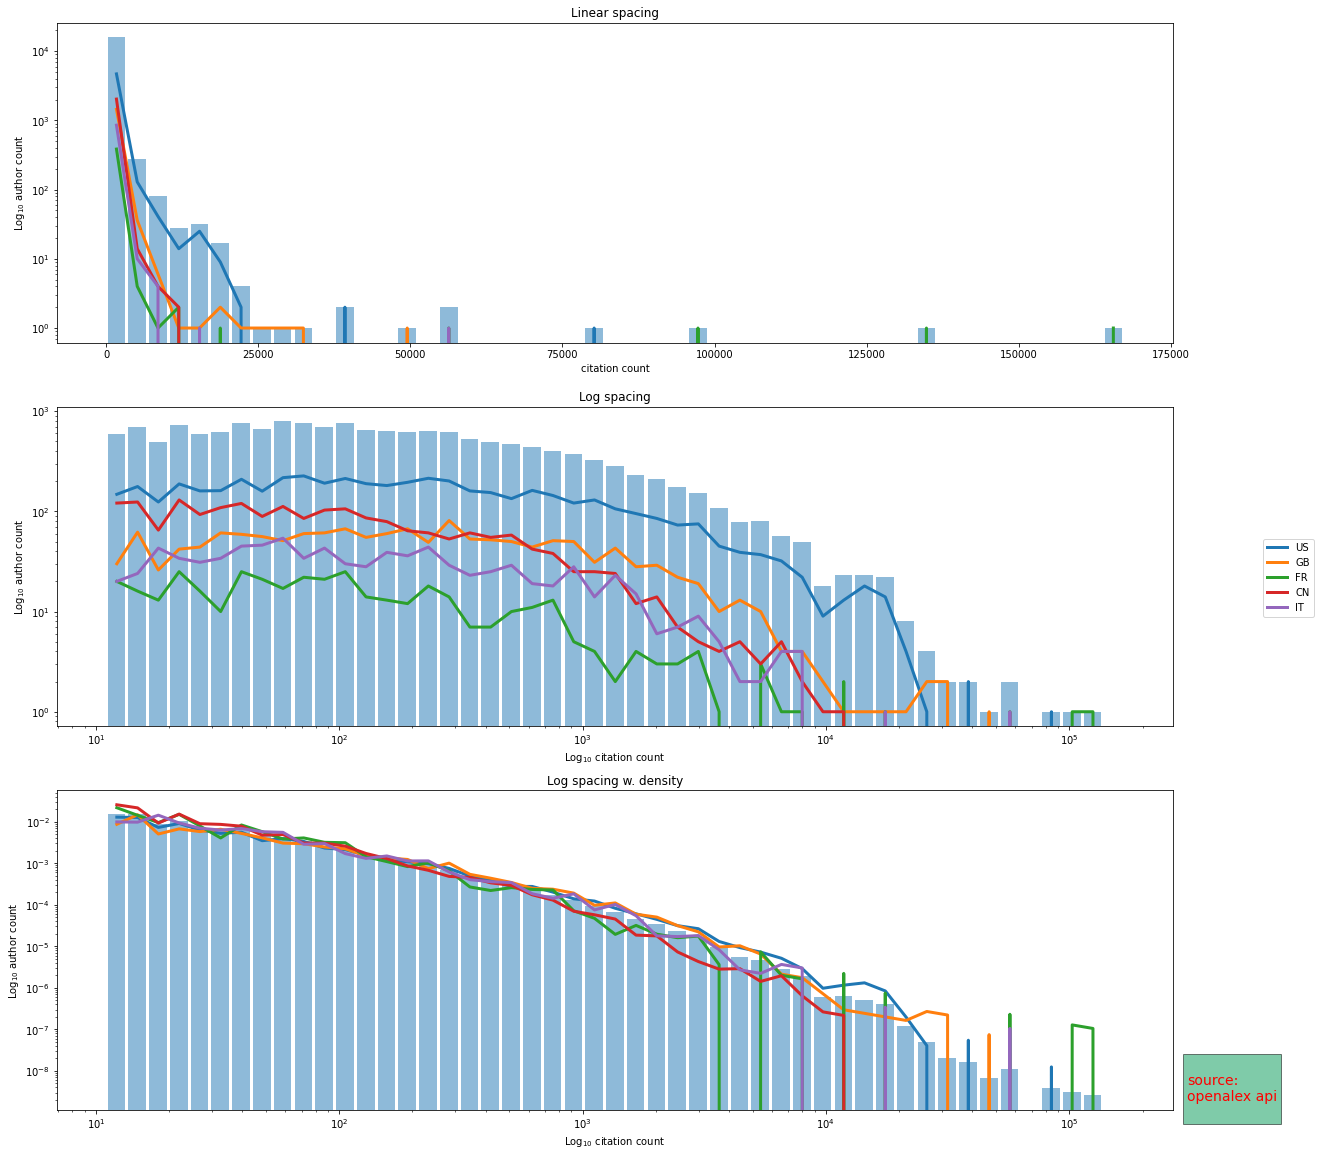

In [6]:
# Q2
citation_count = citation_df.citation_count[citation_df.citation_count > 0]

fig,ax = plt.subplots(3,1,figsize=(20,20))

# Linear
linbins = np.linspace(min(citation_count),
                      max(citation_count),50)
hist, edges = np.histogram(citation_count,bins=linbins)
xlin = (edges[:-1]+edges[1:])/2 # get midpoints between edges
width = linbins[1:]-linbins[:-1] # 

ax[0].bar(xlin,hist,width=width*0.85,alpha=0.5)
ax[0].set_xlabel("citation count")
ax[0].set_ylabel("Log$_{10}$ author count")
ax[0].set_yscale("log")
ax[0].set_title("Linear spacing")

# Log
logbins = np.logspace(np.log10(min(citation_count)),
                      np.log10(max(citation_count)),50)
hist, edges = np.histogram(citation_count,bins=logbins)
xlog = (edges[:-1]+edges[1:])/2 # get midpoints between edges
width = logbins[1:]-logbins[:-1] # 

ax[1].bar(xlog,hist,width=width*0.85,alpha=0.5)
ax[1].set_xlabel("Log$_{10}$ citation count")
ax[1].set_ylabel("Log$_{10}$ author count")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_title("Log spacing")

# Log density
hist, edges = np.histogram(citation_count,bins=logbins, density=True)

ax[2].bar(xlog,hist,width=width*0.85,alpha=0.5)
ax[2].set_xlabel("Log$_{10}$ citation count")
ax[2].set_ylabel("Log$_{10}$ author count ")
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_title("Log spacing w. density")

# Q3
top_cc = citation_df.groupby("last_country_code")["citation_count"].sum().sort_values(ascending=False)[:5].index
for country in top_cc:
    country_count = citation_df[citation_df.last_country_code == country]["citation_count"]
    hist_c, _ = np.histogram(country_count,bins=linbins)
    ax[0].plot(xlin,hist_c, label=country,linewidth=3)
    
    hist_c, _ = np.histogram(country_count,bins=logbins)
    ax[1].plot(xlog,hist_c, label=country,linewidth=3)
    
    hist_c, _ = np.histogram(country_count,bins=logbins, density=True)
    ax[2].plot(xlog,hist_c, label=country,linewidth=3)
fig.legend(top_cc,loc="right")
fig.text(0.91, 0.12, '\nsource:\nopenalex api\n',fontsize=14,color="red", bbox={"facecolor":"#095","alpha":0.5})
plt.show()

# Week 4

In [2]:
# P1
full_paper = pd.read_pickle("full_df_paper.pickle")
order = lambda x,y: (min(x,y),max(x,y))

wedge = {}
for collab in full_paper.author_ids:
    for i in range(len(collab)):
        for j in range(i+1,len(collab)):
            pair = order(collab[i],collab[j])
            wedge[pair] = wedge.get(pair,0) + 1

# full_paper
# wedge

# P2 
G = nx.Graph()
for key,val in wedge.items():
    G.add_edge(*key, weight=val)

# P3
full_author = pd.read_pickle("full_df_researchers.pickle")
full_paper  = pd.read_pickle("full_df_paper.pickle")

full_author.insert(4,"citation_count",0)
full_author.insert(5,"first_publish",9999)
for count,pyear,authors in tqdm(full_paper[["cited_by_count","publication_year","author_ids"]].iloc,total=len(full_paper)):
    for author in authors:
        full_author.citation_count[full_author.id==author] += count
        if full_author["first_publish"][full_author.id==author].iloc[0] > pyear:
            full_author["first_publish"][full_author.id==author] = pyear

full_author.first_publish = full_author.first_publish.replace(9999,None)
full_author = full_author.rename(columns={"last_country_code":"country"})
node_attr = full_author[["id","display_name","country","first_publish"]].set_index('id').to_dict("index")
nx.set_node_attributes(G, node_attr)

from networkx.readwrite import json_graph
import json
with open('graph.json', 'w') as f:
    json.dump(json_graph.node_link_data(G), f)
# json_graph.node_link_data(G)

  0%|          | 0/31681 [00:00<?, ?it/s]c:\Users\son22\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:2221: RuntimeWarning: invalid value encountered in cast
  casted = element.astype(dtype)
100%|██████████| 31681/31681 [03:32<00:00, 148.77it/s]


In [29]:
print("--- Net metric ---")
print("N nodes:",G.number_of_nodes())
print("N edges:",G.number_of_edges())
print("Network density:",G.number_of_edges()/sum(range(G.number_of_nodes()))) # 
print("N sub graphs:",len(list(nx.connected_components(G))))
print("N isolated nodes",nx.number_of_isolates(G))

--- Net metric ---
N nodes: 16284
N edges: 60279
Network density: 0.00045467441641442304
N sub graphs: 108
N isolated nodes 0


In [4]:
print("--- Degree analysis ---")
deg_df = pd.DataFrame(list(G.degree()),columns=["id","Node degree"])
print(deg_df.describe())
print("Mode:", deg_df["Node degree"].value_counts().idxmax())

wgt_df = pd.DataFrame([w["weight"] for _,_,w in G.edges(data=True)],columns=["Node weights"])
print(wgt_df.describe())
print("Mode:",wgt_df.value_counts().idxmax())

--- Degree analysis ---
        Node degree
count  16284.000000
mean       7.403464
std        9.163333
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max      229.000000
Mode: 4
       Node weights
count  60279.000000
mean       1.721080
std        2.141908
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       85.000000
Mode: (1,)


In [31]:
print("--- Top authors ---")
top_authors = deg_df.sort_values(by="Node degree",ascending=False)[:5]

g = G.copy()
top_authors = pd.merge(top_authors,full_author[full_author.id.isin(top_authors.id)][["id","display_name","works_count","citation_count","first_publish","country","works_api_url"]])
print(top_authors)
for ta in top_authors.id:
    g.remove_node(ta)

print()
print("Without top 5 authors, n subgraphs =",len(list(nx.connected_components(g))))

--- Top authors ---
            id  Node degree         display_name  works_count  citation_count  \
0  A5052134746          229            Yuan Chen         4810            4796   
1  A5088141761          198    Jonathan D. Cohen          736           56716   
2  A5036031567          197           Miao Zhang         3859            2224   
3  A5044944954          178        Lyle H. Ungar          525            7270   
4  A5017914184          150  Stephan Lewandowsky          539           12905   

  first_publish country  \
0          1994      CN   
1          1990      IT   
2          2000      CN   
3          1988      US   
4          1983      AU   

                                                 works_api_url  
0  https://api.openalex.org/works?filter=author.id:A5052134746  
1  https://api.openalex.org/works?filter=author.id:A5088141761  
2  https://api.openalex.org/works?filter=author.id:A5036031567  
3  https://api.openalex.org/works?filter=author.id:A5044944954  
4  ht

> 1. **Network Metrics:**
>    - What is the total number of nodes (authors) and links (collaborations) in the network? 

There are in total of 16286 nodes/authors and 60284 edges/collaborations

>    - Calculate the network's density (the ratio of actual links to the maximum possible number of links). Would you say that the network is sparse? Justify your answer.

The ratio between actual edges and total is 0.045% and is therefore very sparse.

>    - Is the network fully connected (i.e., is there a direct or indirect path between every pair of nodes within the network), or is it disconnected?

The network is disconnected

>    - If the network is disconnected, how many connected components does it have? A connected component is defined as a subset of nodes within the network where a path exists between any pair of nodes in that subset. 

There are 108 subgraphs

>    - How many isolated nodes are there in your network?  An isolated node is defined as a node with no connections to any other node in the network.

There are 0 nodes which are isolated/has degree 0

>    - Discuss the results above on network density, and connectivity. Are your findings in line with what you expected? Why?  __(answer in max 150 words)__

As there are 16286 reseearchers, the network would be expected to be sparse, as a ratio of 1% would require that each researcher would collaborate with 162 others on average, which is very unlikely.
The connectivity are also within expectation as we are targeting researchers from IC2S2 and their co-researchers, which has an increased chance for collaborating with each other and there are therefore few subgraphs.

> 3. **Degree Analysis:**
>    - Compute the average, median, mode, minimum, and maximum degree of the nodes. Perform the same analysis for node strength (weighted degree). What do these metrics tell us about the network? __(answer in max 150 words)__

Nodes have an average degree of ~7 which means that they statistically collab with 7 other researchers throughout their studies. The numbers are however closer to 6 (being the median) which is a more accurate metric as it isn't as much affected by outliers. The min is 1 which could mean that they are relative new and the largest is 229, which either is due to working in a large project in a institute or is just a really popular person. <br>

The node weights are on average 1.5~2 which means that they collab with the same person either once or twice, with median staying on 1 which is also the lowest. The maximum is 85 which indicates that they are really really good friends.

> 4. **Top Authors:**
>    - Identify the top 5 authors by degree. What role do these node play in the network? 

These authors are a major factor for the graph to be as connected as possible/has few subgraphs. Removing them although only increased subgraph count by 49, which indicates that there are still authors with high node degree.  

>    - Research these authors online. What areas do they specialize in? Do you think that their work aligns with the themes of Computational Social Science? If not, what could be possible reasons? __(answer in max 150 words)__

The areas they specialise in are biology and computer science, with secondary being physics and mathematics. Biology is a suprise, but by viewing topics such as the effect of medicine on society or human behaivour, it makes sense to be included. The fields are therefore quite aligned within the theme of Computational Social Science.


### Ex 2

In [ ]:
G_sub = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
visualize(G_sub)

# See "Week 4 graph.png"

(None, None)